In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
transform = ToTensor()

mnist_train = torchvision.datasets.MNIST(root="data", train=True, transform=transform, target_transform=None, download=True)
mnist_test = torchvision.datasets.MNIST(root="data", train=False, transform=transform, target_transform=None, download=True)

mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [3]:
train_DataLoader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
test_DataLoader = DataLoader(dataset=mnist_test, batch_size=32, shuffle=True)

train_DataLoader, test_DataLoader

(<torch.utils.data.dataloader.DataLoader at 0x15438ea50>,
 <torch.utils.data.dataloader.DataLoader at 0x1543720d0>)

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [5]:
class LinearVAE(nn.Module):
    def __init__(self, input_features, encoder_hidden, latent_dim, decoder_hidden):
        super().__init__()

        self.base_encode = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=encoder_hidden),
            nn.ReLU(),
            nn.BatchNorm1d(encoder_hidden),
            nn.Linear(in_features=encoder_hidden, out_features=encoder_hidden*2),
            nn.ReLU(),
            nn.BatchNorm1d(encoder_hidden*2)
        )

        self.fc_mu = nn.Linear(in_features=encoder_hidden*2, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=encoder_hidden*2, out_features=latent_dim)

        self.base_decode = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=decoder_hidden),
            nn.ReLU(),
            nn.BatchNorm1d(decoder_hidden),
            nn.Linear(in_features=decoder_hidden, out_features=decoder_hidden*2),
            nn.ReLU(),
            nn.BatchNorm1d(decoder_hidden*2),
            nn.Linear(in_features=decoder_hidden*2, out_features=input_features),
            # nn.Sigmoid()
        )

    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        fc = self.base_encode(x)
        mu = self.fc_mu(fc)
        logvar = self.fc_logvar(fc)
        
        # mu = torch.clamp(mu, min=-10, max=10)
        # logvar = torch.clamp(logvar, min=-10, max=10)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std*eps
        return z, mu, logvar
    
    def decoder(self, z: torch.Tensor) -> torch.Tensor:
        return self.base_decode(z)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z, mu, logvar = self.encoder(x)
        output = self.decoder(z)
        output = torch.clamp(output, min=-10, max=10)
        return output, mu, logvar
    
model1 = LinearVAE(input_features=28*28, encoder_hidden=128, latent_dim=64, decoder_hidden=128)
model1.to(device=device)

model1, next(model1.parameters()).device, sum(torch.numel(i) for i in model1.parameters() if i.requires_grad)

(LinearVAE(
   (base_encode): Sequential(
     (0): Linear(in_features=784, out_features=128, bias=True)
     (1): ReLU()
     (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Linear(in_features=128, out_features=256, bias=True)
     (4): ReLU()
     (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (fc_mu): Linear(in_features=256, out_features=64, bias=True)
   (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
   (base_decode): Sequential(
     (0): Linear(in_features=64, out_features=128, bias=True)
     (1): ReLU()
     (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Linear(in_features=128, out_features=256, bias=True)
     (4): ReLU()
     (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): Linear(in_features=256, out_features=784, bias=True)
   )
 ),
 device(type='mps', index=0),
 41076

In [6]:
from torchinfo import summary

summary(model=model1, input_size=(32, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
LinearVAE                                [32, 1, 28, 28]           [32, 784]                 --                        True
├─Sequential: 1-1                        [32, 784]                 [32, 256]                 --                        True
│    └─Linear: 2-1                       [32, 784]                 [32, 128]                 100,480                   True
│    └─ReLU: 2-2                         [32, 128]                 [32, 128]                 --                        --
│    └─BatchNorm1d: 2-3                  [32, 128]                 [32, 128]                 256                       True
│    └─Linear: 2-4                       [32, 128]                 [32, 256]                 33,024                    True
│    └─ReLU: 2-5                         [32, 256]                 [32, 256]                 --                        --
│    └─

In [7]:
def loss_fn(x, x_hat, mu, logvar, kl_weight=1):
    BCE = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='mean')
    KLD = -0.5*torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) / x.shape[0]
    return BCE + KLD*kl_weight, BCE, KLD

optimizer = torch.optim.Adam(params=model1.parameters(), lr=1e-4)

loss_fn, optimizer

(<function __main__.loss_fn(x, x_hat, mu, logvar, kl_weight=1)>,
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0001
     maximize: False
     weight_decay: 0
 ))

In [8]:
%%time

from tqdm.auto import  tqdm

epochs = 10
batch_train_losses = []
bce_batch_train_losses = []
kld_batch_train_losses = []

batch_test_losses = []
bce_batch_test_losses = []
kld_batch_test_losses = []

model1.to(device=device)

for epoch in tqdm(range(epochs)):
    model1.train()
    train_losses = 0
    bce_train_losses = 0
    kld_train_losses = 0

    test_losses = 0
    bce_test_losses = 0
    kld_test_losses = 0

    for batch, (X, y) in enumerate(train_DataLoader):
        X = X.to(device=device)

        output, mu, logvar = model1(X)
        loss, bce, kld = loss_fn(X.view(X.shape[0], -1), output, mu, logvar, 1)

        train_losses += loss
        bce_train_losses += bce.item()
        kld_train_losses += kld

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%100==0 and epoch%2==0:
            print(f"Batch {batch}, mu: {mu.max()}, logvar: {logvar.max()}, training batch loss: {loss:.2f}, bce: {bce:.2f}, kld: {kld:.2f}")

    train_losses /= len(train_DataLoader)
    batch_train_losses.append(train_losses)

    bce_train_losses /= len(train_DataLoader)
    bce_batch_train_losses.append(bce_train_losses)

    kld_train_losses /= len(train_DataLoader)
    kld_batch_train_losses.append(kld_train_losses)

    model1.eval()
    with torch.inference_mode():
        for X, y in test_DataLoader:
            X = X.to(device=device)

            output, mu, logvar = model1(X)

            loss, bce, kld = loss_fn(X.view(X.shape[0], -1), output, mu, logvar, 1)
            test_losses += loss
            bce_test_losses += bce.item()
            kld_test_losses += kld

        test_losses /= len(test_DataLoader)
        batch_test_losses.append(test_losses)

        bce_test_losses /= len(test_DataLoader)
        bce_batch_test_losses.append(bce_test_losses)

        kld_test_losses /= len(test_DataLoader)
        kld_batch_test_losses.append(kld_test_losses)

    if epoch%2 == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_losses}, Test Loss: {test_losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

Batch 0, mu: 2.225846529006958, logvar: 2.0349314212799072, training batch loss: 0.74, bce: 0.73, kld: 0.01
Batch 100, mu: 2.5760977268218994, logvar: 1.530609130859375, training batch loss: 0.71, bce: 0.70, kld: 0.01
Batch 200, mu: 3.1227381229400635, logvar: 1.2402260303497314, training batch loss: 0.67, bce: 0.66, kld: 0.01
Batch 300, mu: 3.4733335971832275, logvar: 1.017998218536377, training batch loss: 0.63, bce: 0.62, kld: 0.01
Batch 400, mu: 2.9858789443969727, logvar: 1.0552681684494019, training batch loss: 0.56, bce: 0.55, kld: 0.01
Batch 500, mu: 3.4772629737854004, logvar: 0.8470023274421692, training batch loss: 0.49, bce: 0.48, kld: 0.01
Batch 600, mu: 2.984009265899658, logvar: 0.8240256309509277, training batch loss: 0.41, bce: 0.40, kld: 0.01
Batch 700, mu: 2.8016817569732666, logvar: 1.0689798593521118, training batch loss: 0.35, bce: 0.34, kld: 0.01
Batch 800, mu: 2.9023938179016113, logvar: 0.7761478424072266, training batch loss: 0.31, bce: 0.30, kld: 0.01
Batch 9

 10%|█         | 1/10 [00:17<02:38, 17.64s/it]

Epoch: 0, Train Loss: 0.36025720834732056, Test Loss: 0.18197248876094818


 20%|██        | 2/10 [00:35<02:20, 17.58s/it]

Batch 0, mu: 2.7433664798736572, logvar: -0.03834749758243561, training batch loss: 0.15, bce: 0.14, kld: 0.02
Batch 100, mu: 2.7114603519439697, logvar: 0.12649492919445038, training batch loss: 0.17, bce: 0.15, kld: 0.02
Batch 200, mu: 2.9242825508117676, logvar: -0.05541339889168739, training batch loss: 0.18, bce: 0.17, kld: 0.02
Batch 300, mu: 2.800508975982666, logvar: -0.046452417969703674, training batch loss: 0.17, bce: 0.15, kld: 0.02
Batch 400, mu: 3.855433464050293, logvar: 0.1807423233985901, training batch loss: 0.16, bce: 0.15, kld: 0.02
Batch 500, mu: 3.4008350372314453, logvar: 0.010913573205471039, training batch loss: 0.16, bce: 0.14, kld: 0.02
Batch 600, mu: 3.3879177570343018, logvar: 0.13568726181983948, training batch loss: 0.16, bce: 0.14, kld: 0.02
Batch 700, mu: 2.5616259574890137, logvar: -0.09667807817459106, training batch loss: 0.15, bce: 0.13, kld: 0.02
Batch 800, mu: 3.120314359664917, logvar: -0.014690086245536804, training batch loss: 0.16, bce: 0.14, 

 30%|███       | 3/10 [00:53<02:03, 17.71s/it]

Epoch: 2, Train Loss: 0.1576785445213318, Test Loss: 0.14431899785995483


 40%|████      | 4/10 [01:11<01:47, 17.99s/it]

Batch 0, mu: 3.489757537841797, logvar: 0.13542640209197998, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 100, mu: 3.643688440322876, logvar: 0.14142832159996033, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 200, mu: 3.538956880569458, logvar: 0.11066964268684387, training batch loss: 0.15, bce: 0.14, kld: 0.02
Batch 300, mu: 2.9524965286254883, logvar: 0.10720561444759369, training batch loss: 0.16, bce: 0.14, kld: 0.02
Batch 400, mu: 2.734302043914795, logvar: 0.22776591777801514, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 500, mu: 3.0497817993164062, logvar: 0.14111393690109253, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 600, mu: 3.43347430229187, logvar: 0.21406689286231995, training batch loss: 0.16, bce: 0.14, kld: 0.02
Batch 700, mu: 2.84834623336792, logvar: 0.16468310356140137, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 800, mu: 2.9799954891204834, logvar: 0.14992858469486237, training batch loss: 0.14, bce: 0.12, kld: 0.02
Ba

 50%|█████     | 5/10 [01:29<01:29, 17.94s/it]

Epoch: 4, Train Loss: 0.14290989935398102, Test Loss: 0.1315361112356186


 60%|██████    | 6/10 [01:47<01:11, 17.85s/it]

Batch 0, mu: 2.968425989151001, logvar: 0.07661024481058121, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 100, mu: 3.3772337436676025, logvar: 0.12424283474683762, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 200, mu: 2.895521402359009, logvar: 0.12436184287071228, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 300, mu: 3.3301949501037598, logvar: 0.1271112710237503, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 400, mu: 3.2726681232452393, logvar: 0.13539227843284607, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 500, mu: 2.9133388996124268, logvar: 0.11115479469299316, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 600, mu: 3.0748422145843506, logvar: 0.16614654660224915, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 700, mu: 2.916876792907715, logvar: 0.1329788714647293, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 800, mu: 3.635364532470703, logvar: 0.1128651350736618, training batch loss: 0.13, bce: 0.11, kld: 0.02
B

 70%|███████   | 7/10 [02:03<00:52, 17.45s/it]

Epoch: 6, Train Loss: 0.1345929056406021, Test Loss: 0.1241522952914238


 80%|████████  | 8/10 [02:21<00:34, 17.43s/it]

Batch 0, mu: 3.223984479904175, logvar: 0.1753617376089096, training batch loss: 0.12, bce: 0.10, kld: 0.02
Batch 100, mu: 3.750890016555786, logvar: 0.11838282644748688, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 200, mu: 2.562655448913574, logvar: 0.14386048913002014, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 300, mu: 2.9953155517578125, logvar: 0.2521851360797882, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 400, mu: 3.4449918270111084, logvar: 0.26077309250831604, training batch loss: 0.12, bce: 0.10, kld: 0.02
Batch 500, mu: 3.183992624282837, logvar: 0.11525271832942963, training batch loss: 0.12, bce: 0.10, kld: 0.02
Batch 600, mu: 2.832573175430298, logvar: 0.19186019897460938, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batch 700, mu: 3.229613780975342, logvar: 0.22244423627853394, training batch loss: 0.13, bce: 0.11, kld: 0.02
Batch 800, mu: 2.836387872695923, logvar: 0.2659110724925995, training batch loss: 0.14, bce: 0.12, kld: 0.02
Batc

 90%|█████████ | 9/10 [02:38<00:17, 17.58s/it]

Epoch: 8, Train Loss: 0.12943503260612488, Test Loss: 0.11987381428480148


100%|██████████| 10/10 [02:55<00:00, 17.57s/it]

CPU times: user 2min 46s, sys: 17.7 s, total: 3min 4s
Wall time: 2min 55s


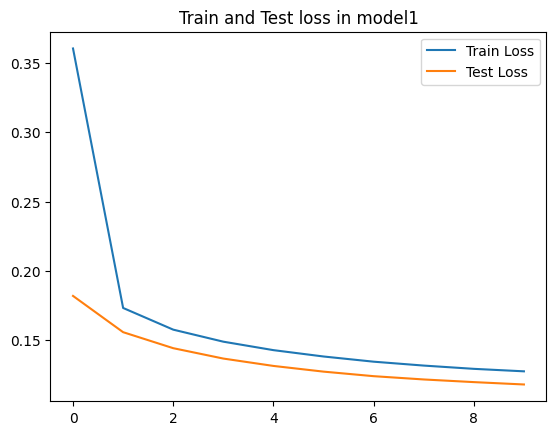

In [9]:
plt.plot([i.item() for i in batch_train_losses], label="Train Loss")
plt.plot([i.item() for i in batch_test_losses], label="Test Loss")

plt.title("Train and Test loss in model1")
plt.legend()
plt.show()

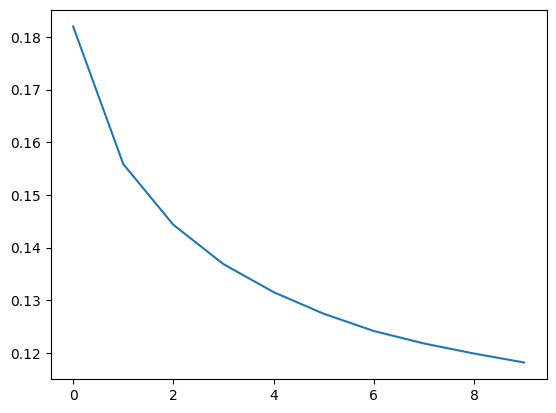

In [10]:
plt.plot([i.item() for i in batch_test_losses], label="Test")

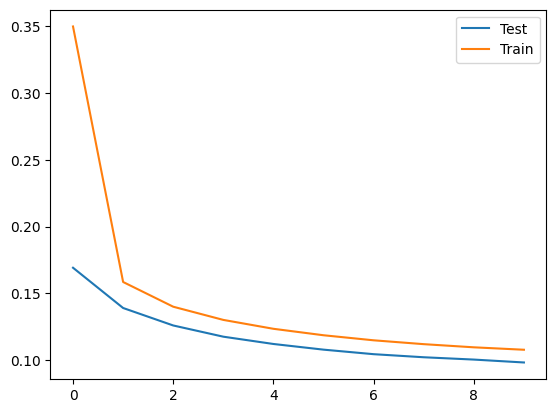

In [11]:
plt.plot([i for i in bce_batch_test_losses], label="Test")
plt.plot([i for i in bce_batch_train_losses], label="Train")

plt.legend()
plt.show()

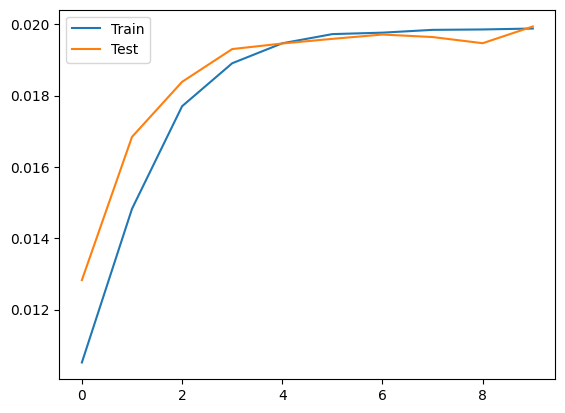

In [12]:
plt.plot([i.cpu().item() for i in kld_batch_train_losses], label="Train")
plt.plot([i.cpu().item() for i in kld_batch_test_losses], label="Test")

plt.legend()
plt.show()

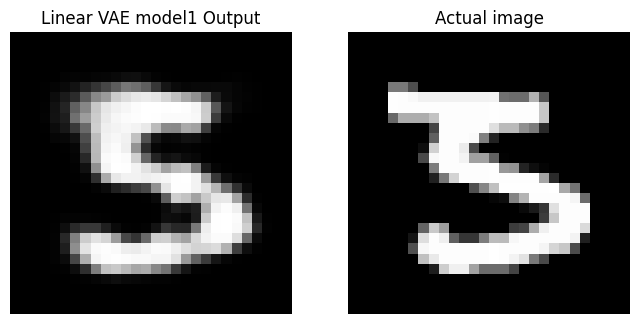

In [13]:
model1.eval()

img = next(iter(test_DataLoader))[0][0]

with torch.no_grad():
    output, mu, logvar = model1(img.to(device=device))

output = torch.reshape(input=output, shape=(1, 28, 28))
output = torch.sigmoid(output)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(output.cpu().squeeze().numpy(), cmap='gray')
ax[0].set_title("Linear VAE model1 Output")
ax[1].imshow(img.cpu().squeeze().numpy(), cmap='gray')
ax[1].set_title("Actual image")

ax[0].axis(False)
ax[1].axis(False)

plt.show()

So complex model, and still bad output. 
### Let's try a simpler model and see results

In [14]:
class LinearVAE(nn.Module):
    def __init__(self, input_features, encoder_hidden, latent_dim, decoder_hidden):
        super().__init__()

        self.base_encode = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=encoder_hidden),
            nn.ReLU(),
            nn.Linear(in_features=encoder_hidden, out_features=encoder_hidden*2),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(in_features=encoder_hidden*2, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=encoder_hidden*2, out_features=latent_dim)

        self.base_decode = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=decoder_hidden),
            nn.ReLU(),
            nn.Linear(in_features=decoder_hidden, out_features=decoder_hidden*2),
            nn.ReLU(),
            nn.Linear(in_features=decoder_hidden*2, out_features=input_features)
        )

    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        fc = self.base_encode(x)
        mu = self.fc_mu(fc)
        logvar = self.fc_logvar(fc)
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std*eps
        return z, mu, logvar
    
    def decoder(self, z: torch.Tensor) -> torch.Tensor:
        return self.base_decode(z)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z, mu, logvar = self.encoder(x)
        output = self.decoder(z)
        return output, mu, logvar
    
model2 = LinearVAE(input_features=28*28, encoder_hidden=128, latent_dim=64, decoder_hidden=128)
model2.to(device=device)

def loss_fn(x, x_hat, mu, logvar):
    BCE = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='sum')
    KLD = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = torch.optim.Adam(params=model2.parameters(), lr=1e-3)

model2, next(model2.parameters()).device, sum(torch.numel(i) for i in model2.parameters() if i.requires_grad)

(LinearVAE(
   (base_encode): Sequential(
     (0): Linear(in_features=784, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=256, bias=True)
     (3): ReLU()
   )
   (fc_mu): Linear(in_features=256, out_features=64, bias=True)
   (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
   (base_decode): Sequential(
     (0): Linear(in_features=64, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=784, bias=True)
   )
 ),
 device(type='mps', index=0),
 409232)

In [15]:
%%time

from tqdm.auto import  tqdm

epochs = 10
batch_train_losses = []
batch_test_losses = []

model2.to(device=device)

for epoch in tqdm(range(epochs)):
    model1.train()
    train_losses = 0
    test_losses = 0

    for batch, (X, y) in enumerate(train_DataLoader):
        X = X.to(device=device)

        output, mu, logvar = model2(X)
        loss = loss_fn(X.view(X.shape[0], -1), output, mu, logvar)

        train_losses += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%100==0 and epoch%2==0:
            print(f"Batch {batch}, mu: {mu.max()}, logvar: {logvar.max()}, training batch loss: {loss:.2f}")

    train_losses /= len(train_DataLoader)
    batch_train_losses.append(train_losses)

    model2.eval()
    with torch.inference_mode():
        for X, y in test_DataLoader:
            X = X.to(device=device)

            output, mu, logvar = model2(X)

            loss = loss_fn(X.view(X.shape[0], -1), output, mu, logvar)
            test_losses += loss

        test_losses /= len(test_DataLoader)
        batch_test_losses.append(test_losses)

    if epoch%2 == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_losses}, Test Loss: {test_losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

Batch 0, mu: 0.1541103720664978, logvar: 0.20338767766952515, training batch loss: 17437.17
Batch 100, mu: 1.029617428779602, logvar: 0.30905288457870483, training batch loss: 6623.87
Batch 200, mu: 1.1015342473983765, logvar: 0.14490075409412384, training batch loss: 6423.81
Batch 300, mu: 1.493341326713562, logvar: 0.17580866813659668, training batch loss: 6263.18
Batch 400, mu: 1.8534265756607056, logvar: 0.29519757628440857, training batch loss: 5542.80
Batch 500, mu: 1.682174563407898, logvar: 0.36043494939804077, training batch loss: 5667.67
Batch 600, mu: 2.2472007274627686, logvar: 0.2852162718772888, training batch loss: 5980.45
Batch 700, mu: 2.8870444297790527, logvar: 0.17487037181854248, training batch loss: 5323.01
Batch 800, mu: 2.240295648574829, logvar: 0.12489862740039825, training batch loss: 4943.06
Batch 900, mu: 3.2470195293426514, logvar: 0.164066344499588, training batch loss: 4753.10
Batch 1000, mu: 3.037126064300537, logvar: 0.19186332821846008, training batch

 10%|█         | 1/10 [00:11<01:42, 11.41s/it]

Epoch: 0, Train Loss: 5201.00048828125, Test Loss: 4157.88134765625


 20%|██        | 2/10 [00:22<01:30, 11.30s/it]

Batch 0, mu: 3.2557549476623535, logvar: 0.13488250970840454, training batch loss: 3854.41
Batch 100, mu: 2.894294023513794, logvar: 0.1366337388753891, training batch loss: 3939.22
Batch 200, mu: 3.054924249649048, logvar: 0.1719352900981903, training batch loss: 3721.64
Batch 300, mu: 3.094846487045288, logvar: 0.1492730975151062, training batch loss: 4090.06
Batch 400, mu: 2.978888750076294, logvar: 0.1240202859044075, training batch loss: 3598.23
Batch 500, mu: 2.975745916366577, logvar: 0.11104266345500946, training batch loss: 3775.72
Batch 600, mu: 3.213001012802124, logvar: 0.10122039914131165, training batch loss: 4108.51
Batch 700, mu: 2.688894033432007, logvar: 0.10178252309560776, training batch loss: 3231.11
Batch 800, mu: 3.0050060749053955, logvar: 0.09788855910301208, training batch loss: 3396.64
Batch 900, mu: 3.5107827186584473, logvar: 0.1141144186258316, training batch loss: 3626.31
Batch 1000, mu: 2.836587905883789, logvar: 0.11285711824893951, training batch loss:

 30%|███       | 3/10 [00:33<01:18, 11.27s/it]

Epoch: 2, Train Loss: 3718.202392578125, Test Loss: 3627.302001953125


 40%|████      | 4/10 [00:45<01:07, 11.25s/it]

Batch 0, mu: 3.778388023376465, logvar: 0.09753582626581192, training batch loss: 3618.00
Batch 100, mu: 2.5352303981781006, logvar: 0.12894384562969208, training batch loss: 3564.83
Batch 200, mu: 3.2278826236724854, logvar: 0.12198053300380707, training batch loss: 3426.48
Batch 300, mu: 2.5301434993743896, logvar: 0.10695512592792511, training batch loss: 3697.72
Batch 400, mu: 2.5791895389556885, logvar: 0.10746720433235168, training batch loss: 3559.69
Batch 500, mu: 2.6357314586639404, logvar: 0.09387875348329544, training batch loss: 3477.07
Batch 600, mu: 2.4978625774383545, logvar: 0.1677326112985611, training batch loss: 3608.53
Batch 700, mu: 2.5194478034973145, logvar: 0.10650201141834259, training batch loss: 3508.76
Batch 800, mu: 2.824737787246704, logvar: 0.13682879507541656, training batch loss: 3373.49
Batch 900, mu: 2.7085041999816895, logvar: 0.09417008608579636, training batch loss: 3451.21
Batch 1000, mu: 2.8437438011169434, logvar: 0.10337431728839874, training b

 50%|█████     | 5/10 [00:56<00:56, 11.26s/it]

Epoch: 4, Train Loss: 3553.57275390625, Test Loss: 3508.924560546875


 60%|██████    | 6/10 [01:08<00:45, 11.47s/it]

Batch 0, mu: 2.699676036834717, logvar: 0.11498410999774933, training batch loss: 3528.66
Batch 100, mu: 3.014416456222534, logvar: 0.10840189456939697, training batch loss: 3273.35
Batch 200, mu: 2.479369878768921, logvar: 0.10843387246131897, training batch loss: 3416.18
Batch 300, mu: 2.6755974292755127, logvar: 0.1154751256108284, training batch loss: 3521.21
Batch 400, mu: 2.793715715408325, logvar: 0.12297119945287704, training batch loss: 3747.42
Batch 500, mu: 3.001824378967285, logvar: 0.11703839153051376, training batch loss: 3288.06
Batch 600, mu: 3.042499303817749, logvar: 0.10904597491025925, training batch loss: 3341.27
Batch 700, mu: 3.147172689437866, logvar: 0.15583005547523499, training batch loss: 3238.55
Batch 800, mu: 2.6923255920410156, logvar: 0.13547523319721222, training batch loss: 3391.32
Batch 900, mu: 2.509953498840332, logvar: 0.09768982231616974, training batch loss: 3406.02
Batch 1000, mu: 2.5904204845428467, logvar: 0.13675545156002045, training batch l

 70%|███████   | 7/10 [01:19<00:34, 11.47s/it]

Epoch: 6, Train Loss: 3475.133544921875, Test Loss: 3451.411376953125


 80%|████████  | 8/10 [01:31<00:22, 11.42s/it]

Batch 0, mu: 2.918382167816162, logvar: 0.1294080913066864, training batch loss: 3720.48
Batch 100, mu: 2.809417963027954, logvar: 0.15160825848579407, training batch loss: 3924.11
Batch 200, mu: 2.522988796234131, logvar: 0.10833624005317688, training batch loss: 3376.37
Batch 300, mu: 2.946580410003662, logvar: 0.10844183713197708, training batch loss: 3380.92
Batch 400, mu: 3.007089138031006, logvar: 0.113615021109581, training batch loss: 3484.85
Batch 500, mu: 2.8452346324920654, logvar: 0.11549199372529984, training batch loss: 3431.96
Batch 600, mu: 2.7139298915863037, logvar: 0.09219171106815338, training batch loss: 3371.24
Batch 700, mu: 3.071258306503296, logvar: 0.13690467178821564, training batch loss: 3413.46
Batch 800, mu: 2.7920639514923096, logvar: 0.11961695551872253, training batch loss: 3497.55
Batch 900, mu: 2.883046865463257, logvar: 0.11148692667484283, training batch loss: 3013.97
Batch 1000, mu: 3.238816499710083, logvar: 0.12974019348621368, training batch los

 90%|█████████ | 9/10 [01:42<00:11, 11.41s/it]

Epoch: 8, Train Loss: 3426.48193359375, Test Loss: 3413.459716796875


100%|██████████| 10/10 [01:53<00:00, 11.40s/it]

CPU times: user 1min 56s, sys: 13.8 s, total: 2min 10s
Wall time: 1min 54s


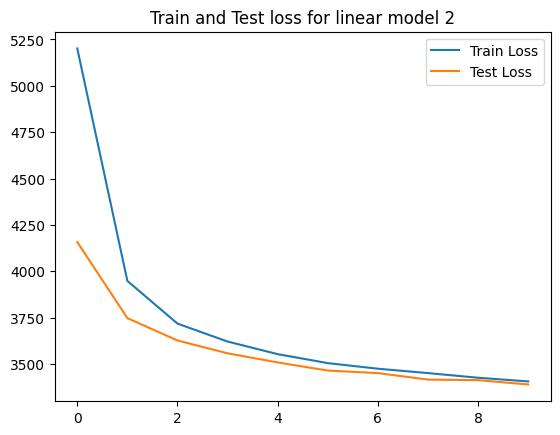

In [16]:
plt.plot([i.item() for i in batch_train_losses], label="Train Loss")
plt.plot([i.item() for i in batch_test_losses], label="Test Loss")

plt.title("Train and Test loss for linear model 2")

plt.legend()

plt.show()

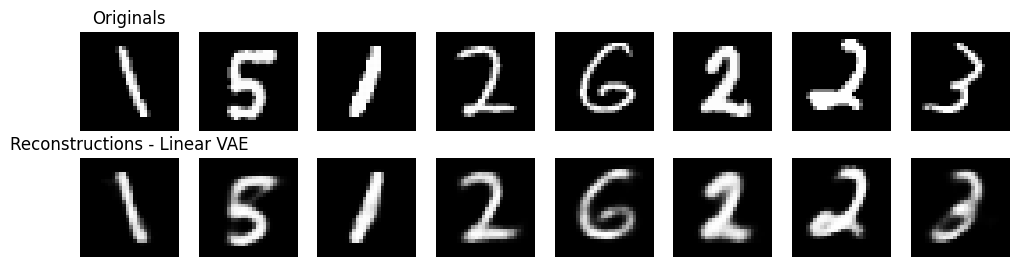

In [17]:
import matplotlib.pyplot as plt

model2.eval()
with torch.no_grad():
    x, _ = next(iter(train_DataLoader))
    x = x.to(device)
    x_hat_logits, _, _ = model2(x)
    x_hat = torch.sigmoid(x_hat_logits)
    
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(x[i].view(28, 28).cpu(), cmap='gray')
        axes[1, i].imshow(x_hat[i].view(28, 28).cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    axes[0, 0].set_title("Originals")
    axes[1, 0].set_title("Reconstructions - Linear VAE")
    plt.show()


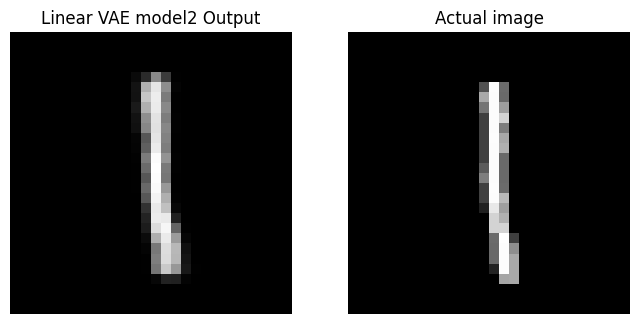

In [18]:
model2.eval()

img = next(iter(test_DataLoader))[0][0]

with torch.no_grad():
    output, mu, logvar = model2(img.to(device=device))

output = torch.sigmoid(torch.reshape(input=output, shape=(1, 28, 28)))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(output.cpu().squeeze().numpy(), cmap='gray')
ax[0].set_title("Linear VAE model2 Output")
ax[1].imshow(img.cpu().squeeze().numpy(), cmap='gray')
ax[1].set_title("Actual image")

ax[0].axis(False)
ax[1].axis(False)

plt.show()

This is quiet good, now let's try Conv VAEs

In [19]:
class ConvVAE(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_channel, decoder_channels):
        super().__init__()

        self.base_encode = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=encoder_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=encoder_channels, out_channels=encoder_channels*2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=encoder_channels*2, out_channels=latent_channel, kernel_size=7),
            nn.ReLU()
        )

        self.middle_encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=12, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU()
        )

        self.conv_mu = nn.Linear(in_features=128, out_features=12)
        self.conv_logvar = nn.Linear(in_features=128, out_features=12)

        self.base_decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_channel, out_channels=decoder_channels*2, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=decoder_channels*2, out_channels=decoder_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=decoder_channels, out_channels=input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        conv = self.base_encode(x)
        middle = self.middle_encode(conv)

        mu = self.conv_mu(middle)
        logvar = self.conv_logvar(middle)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std*eps
        return z, mu, logvar
    
    def decoder(self, z: torch.Tensor) -> torch.Tensor:
        z = z.reshape(shape=(z.shape[0], z.shape[1], 1, 1))
        return self.base_decode(z)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z, mu, logvar = self.encoder(x)
        output = self.decoder(z)
        return output, mu, logvar
    
convModel = ConvVAE(input_channels=1, encoder_channels=7, latent_channel=12, decoder_channels=7)
convModel.to(device=device)

convModel, next(convModel.parameters()).device, sum(torch.numel(i) for i in convModel.parameters() if i.requires_grad)

(ConvVAE(
   (base_encode): Sequential(
     (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(7, 14, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (3): ReLU()
     (4): Conv2d(14, 12, kernel_size=(7, 7), stride=(1, 1))
     (5): ReLU()
   )
   (middle_encode): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=12, out_features=64, bias=True)
     (2): ReLU()
     (3): Linear(in_features=64, out_features=128, bias=True)
     (4): ReLU()
   )
   (conv_mu): Linear(in_features=128, out_features=12, bias=True)
   (conv_logvar): Linear(in_features=128, out_features=12, bias=True)
   (base_decode): Sequential(
     (0): ConvTranspose2d(12, 14, kernel_size=(7, 7), stride=(1, 1))
     (1): ReLU()
     (2): ConvTranspose2d(14, 7, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
     (3): ReLU()
     (4): ConvTranspose2d(7, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),

In [20]:
summary(model=convModel, input_size=(32, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ConvVAE                                  [32, 1, 28, 28]           [32, 1, 28, 28]           --                        True
├─Sequential: 1-1                        [32, 1, 28, 28]           [32, 12, 1, 1]            --                        True
│    └─Conv2d: 2-1                       [32, 1, 28, 28]           [32, 7, 14, 14]           70                        True
│    └─ReLU: 2-2                         [32, 7, 14, 14]           [32, 7, 14, 14]           --                        --
│    └─Conv2d: 2-3                       [32, 7, 14, 14]           [32, 14, 7, 7]            896                       True
│    └─ReLU: 2-4                         [32, 14, 7, 7]            [32, 14, 7, 7]            --                        --
│    └─Conv2d: 2-5                       [32, 14, 7, 7]            [32, 12, 1, 1]            8,244                     True
│    └─

In [21]:
def loss_fn(x_hat, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = torch.optim.Adam(params=convModel.parameters(), lr=1e-3)

In [22]:
%%time

from tqdm.auto import  tqdm

epochs = 10
batch_train_losses = []
batch_test_losses = []

convModel.to(device=device)

for epoch in tqdm(range(epochs)):
    model1.train()
    train_losses = 0
    test_losses = 0

    for batch, (X, y) in enumerate(train_DataLoader):
        X = X.to(device=device)

        output, mu, logvar = convModel(X)
        loss = loss_fn(output, X, mu, logvar)

        train_losses += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%100==0 and epoch%2==0:
            print(f"Batch {batch}, mu: {mu.max()}, logvar: {logvar.max()}, training batch loss: {loss:.2f}")

    train_losses /= len(train_DataLoader)
    batch_train_losses.append(train_losses)

    convModel.eval()
    with torch.inference_mode():
        for X, y in test_DataLoader:
            X = X.to(device=device)

            output, mu, logvar = convModel(X)

            loss = loss_fn(output, X, mu, logvar)
            test_losses += loss

        test_losses /= len(test_DataLoader)
        batch_test_losses.append(test_losses)

    if epoch%2 == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_losses}, Test Loss: {test_losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

Batch 0, mu: 0.06686222553253174, logvar: 0.11373673379421234, training batch loss: 16644.06
Batch 100, mu: 2.218839645385742, logvar: -0.10361993312835693, training batch loss: 7448.91
Batch 200, mu: 1.6020357608795166, logvar: -0.20661750435829163, training batch loss: 6829.21
Batch 300, mu: 2.5749881267547607, logvar: -0.1610003262758255, training batch loss: 6796.52
Batch 400, mu: 2.9444994926452637, logvar: -0.0933571383357048, training batch loss: 6690.76
Batch 500, mu: 2.9214982986450195, logvar: -0.15954288840293884, training batch loss: 6453.49
Batch 600, mu: 2.7035892009735107, logvar: -0.10724807530641556, training batch loss: 6164.97
Batch 700, mu: 2.685110330581665, logvar: -0.10291886329650879, training batch loss: 6541.28
Batch 800, mu: 2.980562686920166, logvar: -0.09886518865823746, training batch loss: 6523.29
Batch 900, mu: 3.0556392669677734, logvar: -0.1064581498503685, training batch loss: 6339.81
Batch 1000, mu: 3.245962619781494, logvar: -0.16552555561065674, tr

 10%|█         | 1/10 [00:46<07:00, 46.74s/it]

Epoch: 0, Train Loss: 6496.99365234375, Test Loss: 5290.173828125


 20%|██        | 2/10 [01:03<03:50, 28.87s/it]

Batch 0, mu: 2.7761878967285156, logvar: 0.028368830680847168, training batch loss: 4569.94
Batch 100, mu: 2.7883102893829346, logvar: 0.027785874903202057, training batch loss: 5070.06
Batch 200, mu: 2.659665107727051, logvar: -0.03834995999932289, training batch loss: 4814.59
Batch 300, mu: 2.7150778770446777, logvar: -0.019541382789611816, training batch loss: 4894.81
Batch 400, mu: 2.877774715423584, logvar: -0.003162362612783909, training batch loss: 4670.96
Batch 500, mu: 2.6602084636688232, logvar: 0.011966809630393982, training batch loss: 4649.43
Batch 600, mu: 3.0461268424987793, logvar: -0.03857986629009247, training batch loss: 4635.85
Batch 700, mu: 2.730940818786621, logvar: 0.014851398766040802, training batch loss: 5209.34
Batch 800, mu: 2.8929636478424072, logvar: 0.06236889958381653, training batch loss: 4631.71
Batch 900, mu: 3.042294502258301, logvar: -0.029383167624473572, training batch loss: 4668.83
Batch 1000, mu: 2.588153839111328, logvar: 0.044378265738487244,

 30%|███       | 3/10 [01:19<02:40, 22.95s/it]

Epoch: 2, Train Loss: 4767.6533203125, Test Loss: 4721.24658203125


 40%|████      | 4/10 [01:34<02:01, 20.17s/it]

Batch 0, mu: 2.650251865386963, logvar: 0.015834171324968338, training batch loss: 4637.43
Batch 100, mu: 2.5318338871002197, logvar: 0.023950442671775818, training batch loss: 4913.28
Batch 200, mu: 3.1138217449188232, logvar: 0.13798187673091888, training batch loss: 4361.60
Batch 300, mu: 2.658599376678467, logvar: 0.022241264581680298, training batch loss: 4871.89
Batch 400, mu: 2.438411235809326, logvar: 0.030783280730247498, training batch loss: 4917.60
Batch 500, mu: 2.4559197425842285, logvar: -0.019520431756973267, training batch loss: 4856.64
Batch 600, mu: 2.60025691986084, logvar: 0.041527390480041504, training batch loss: 4464.77
Batch 700, mu: 2.9630990028381348, logvar: 0.015762366354465485, training batch loss: 4741.60
Batch 800, mu: 3.1269876956939697, logvar: 0.012041576206684113, training batch loss: 5151.83
Batch 900, mu: 2.4009311199188232, logvar: 0.04501410573720932, training batch loss: 4297.78
Batch 1000, mu: 2.6593947410583496, logvar: 0.01580192893743515, tra

 50%|█████     | 5/10 [01:51<01:34, 18.84s/it]

Epoch: 4, Train Loss: 4642.20849609375, Test Loss: 4610.96826171875


 60%|██████    | 6/10 [02:07<01:11, 17.94s/it]

Batch 0, mu: 2.787238121032715, logvar: 0.008131712675094604, training batch loss: 4356.46
Batch 100, mu: 3.0128815174102783, logvar: -0.011947572231292725, training batch loss: 4821.83
Batch 200, mu: 3.1405832767486572, logvar: 0.030385635793209076, training batch loss: 4334.88
Batch 300, mu: 2.4485185146331787, logvar: 0.04982367157936096, training batch loss: 4419.40
Batch 400, mu: 2.4547955989837646, logvar: 0.020392626523971558, training batch loss: 4675.95
Batch 500, mu: 2.9484660625457764, logvar: 0.07061901688575745, training batch loss: 4246.23
Batch 600, mu: 2.393400192260742, logvar: 0.05220553278923035, training batch loss: 4640.23
Batch 700, mu: 2.8992631435394287, logvar: 0.03811310976743698, training batch loss: 4395.80
Batch 800, mu: 2.517378568649292, logvar: -0.0007868781685829163, training batch loss: 4604.88
Batch 900, mu: 2.647764205932617, logvar: 0.011358581483364105, training batch loss: 4419.93
Batch 1000, mu: 3.3592007160186768, logvar: 0.005817100405693054, t

 70%|███████   | 7/10 [02:23<00:52, 17.34s/it]

Epoch: 6, Train Loss: 4597.177734375, Test Loss: 4573.017578125


 80%|████████  | 8/10 [02:39<00:33, 16.83s/it]

Batch 0, mu: 2.4972469806671143, logvar: 0.019679315388202667, training batch loss: 4974.05
Batch 100, mu: 2.2350914478302, logvar: 0.014937793835997581, training batch loss: 4928.76
Batch 200, mu: 2.3288283348083496, logvar: 0.018909916281700134, training batch loss: 4448.97
Batch 300, mu: 2.881019353866577, logvar: 0.010155633091926575, training batch loss: 4668.74
Batch 400, mu: 2.5239059925079346, logvar: 0.024459652602672577, training batch loss: 4633.90
Batch 500, mu: 2.1598939895629883, logvar: 0.032696738839149475, training batch loss: 4351.05
Batch 600, mu: 2.361265182495117, logvar: 0.04712701588869095, training batch loss: 4356.90
Batch 700, mu: 2.9750776290893555, logvar: 0.026159755885601044, training batch loss: 4878.24
Batch 800, mu: 2.621375560760498, logvar: 0.018879815936088562, training batch loss: 4416.49
Batch 900, mu: 2.762644052505493, logvar: -0.014871601946651936, training batch loss: 4767.47
Batch 1000, mu: 2.83670711517334, logvar: 0.061541616916656494, train

 90%|█████████ | 9/10 [02:54<00:16, 16.34s/it]

Epoch: 8, Train Loss: 4570.880859375, Test Loss: 4555.12158203125


100%|██████████| 10/10 [03:09<00:00, 19.00s/it]

CPU times: user 2min 38s, sys: 12.8 s, total: 2min 51s
Wall time: 3min 10s


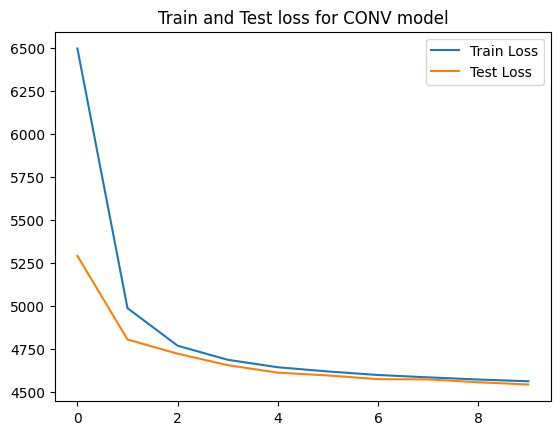

In [23]:
plt.plot([i.item() for i in batch_train_losses], label="Train Loss")
plt.plot([i.item() for i in batch_test_losses], label="Test Loss")

plt.title("Train and Test loss for CONV model")

plt.legend()

plt.show()

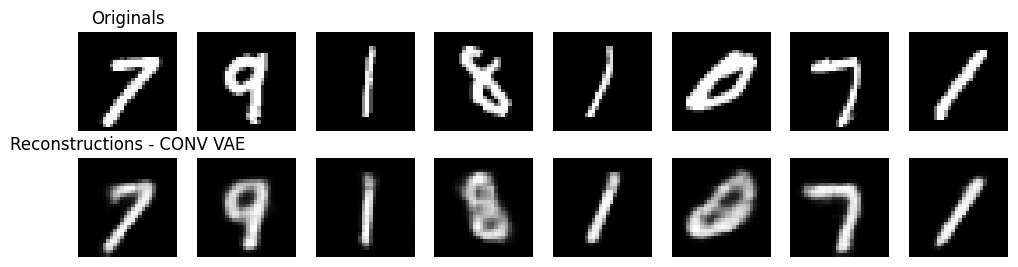

In [24]:
import matplotlib.pyplot as plt

convModel.eval()
with torch.no_grad():
    x, _ = next(iter(train_DataLoader))
    x = x.to(device)
    x_hat_logits, _, _ = convModel(x)
    x_hat = torch.sigmoid(x_hat_logits)
    
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(x[i].view(28, 28).cpu(), cmap='gray')
        axes[1, i].imshow(x_hat[i].view(28, 28).cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    axes[0, 0].set_title("Originals")
    axes[1, 0].set_title("Reconstructions - CONV VAE")
    plt.show()


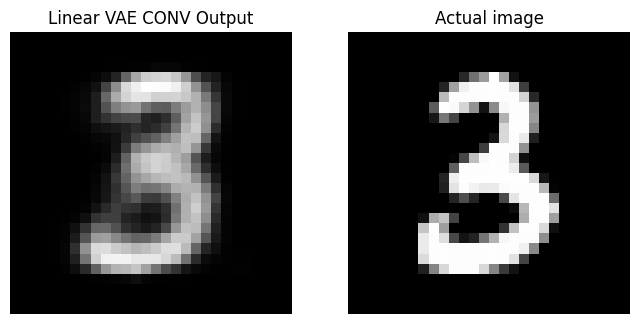

In [25]:
convModel.eval()

img = next(iter(test_DataLoader))[0]
img = img.to(device=device)

with torch.no_grad():
    output, mu, logvar = convModel(img)

output = torch.sigmoid(torch.reshape(input=output, shape=(32, 1, 28, 28)))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(output.cpu().squeeze().numpy()[0], cmap='gray')
ax[0].set_title("Linear VAE CONV Output")
ax[1].imshow(img.cpu().squeeze().numpy()[0], cmap='gray')
ax[1].set_title("Actual image")

ax[0].axis(False)
ax[1].axis(False)

plt.show()

Linear VAEs were better, or maybe we need more tuning to make this perform better.